In [1]:
import torch
import numpy as np
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

from utils import plot_distribs

In [2]:
class GaussianParticle(nn.Module):    
    def __init__(
            self,
            loc=torch.zeros(2),
            covariance_matrix=torch.eye(2),
            requires_grad=True
        ):
        super().__init__()
        self.loc = nn.parameter.Parameter(loc, requires_grad=requires_grad)
        self.covariance_matrix = nn.parameter.Parameter(covariance_matrix, requires_grad=requires_grad)
        self._lmbda = nn.parameter.Parameter(torch.tensor(0.), requires_grad=requires_grad)
        
        self.mvn = MultivariateNormal(loc=self.loc, scale_tril=self.covariance_matrix)

    def lmbda(self):
        # Trick to implement the constraint on lambda:
        return torch.sigmoid(self._lmbda)

    def log_prob(self, X):
        return self.mvn.log_prob(X)

    def sample(self, size=[100]):
        return self.mvn.sample(size)

In [55]:
class GaussianMixture(nn.Module):
    def __init__(self, init):
        super().__init__()
        self.weights = torch.tensor([1])
        self.particles = [init]

    def add_particle(self, particle):
        self.weights = self.weights*(1-particle.lmbda())
        self.weights = torch.cat([self.weights, torch.tensor([particle.lmbda()])])
        self.particles.append(particle)

    def log_prob(self, X):
        prob = torch.zeros(len(X))
        for i in range(len(self.particles)):
            prob += self.weights[i]*torch.exp(self.particles[i].log_prob(X))
        return torch.log(prob)

    def sample(self, size=[100]):
        samples = []
        # sampling in hierarchical model:
        indexes = np.random.choice(len(self.particles), size=size[0], p=self.weights.detach().numpy())
        bincount = np.bincount(indexes)
        for i in range(len(bincount)):
            samples.append(self.particles[i].sample(size=[bincount[i]]))
        return torch.cat(samples)

In [56]:
def FKLLoss(p, q, f, nsamples=1000):
    samples = q.sample([nsamples])

    ps = p.log_prob(samples)
    qs = q.log_prob(samples)
    fs = f.log_prob(samples)

    l = f.lmbda()

    r = torch.exp(ps-qs)
    w = r / r.sum()

    return torch.dot(w, ps - torch.log(l*torch.exp(fs) + (1-l)*torch.exp(qs)))

## First experiment: fitting a Gaussian onto another with FKL

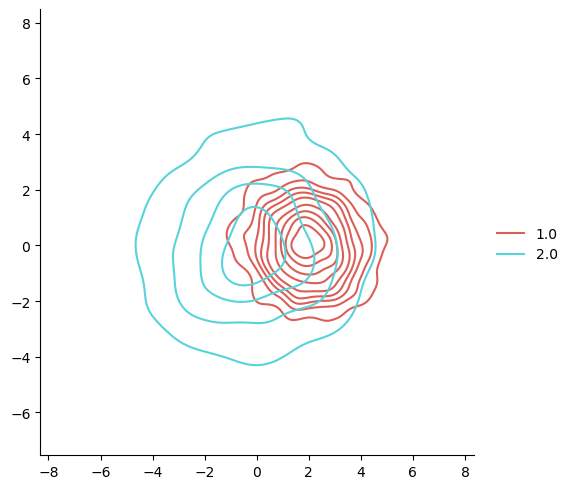

In [57]:
target = GaussianParticle(
    loc=torch.tensor([2,0], dtype=torch.float),
    covariance_matrix=torch.eye(2),
    requires_grad=False
)

# initialize a Gaussian mixture with a diffuse centered gaussian :
init = GaussianParticle(
    loc=torch.zeros(2),
    covariance_matrix=2*torch.eye(2),
    requires_grad=False
)
gm_model = GaussianMixture(init)

plot_distribs([target, gm_model])

In [58]:
new_particle = GaussianParticle(
    loc=torch.randn(2),
    covariance_matrix=torch.eye(2),
    requires_grad=True
)

opt = optim.Adam(new_particle.parameters(), lr=0.001)

losses = []
for step in range(3000):
    loss = FKLLoss(
        f=new_particle,
        q=gm_model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    losses.append(loss.detach().numpy())
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

gm_model.add_particle(new_particle)

step:0, loss:1.342696189880371
step:200, loss:1.0612246990203857
step:400, loss:0.8555765151977539
step:600, loss:0.7107605338096619
step:800, loss:0.5711438655853271
step:1000, loss:0.4457123279571533
step:1200, loss:0.34640267491340637
step:1400, loss:0.22529834508895874
step:1600, loss:0.12014076113700867
step:1800, loss:0.08965890109539032
step:2000, loss:0.07128368318080902
step:2200, loss:0.0605095773935318
step:2400, loss:0.048930197954177856
step:2600, loss:0.0453529953956604
step:2800, loss:0.038954250514507294


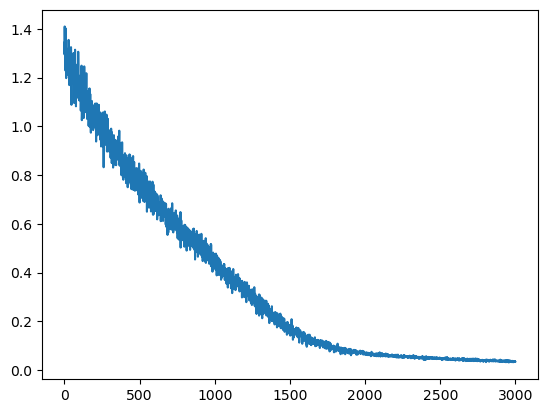

In [59]:
plt.plot(losses)
plt.show()

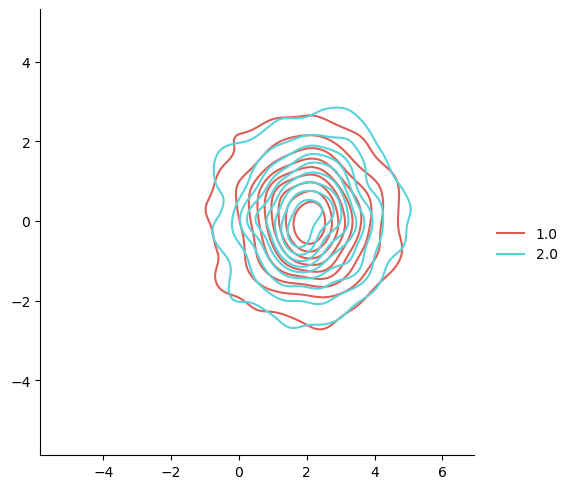

In [60]:
plot_distribs([gm_model, target])

## Second experiment, fitting a multimodal target with boosting:

We first define the multimodal target:

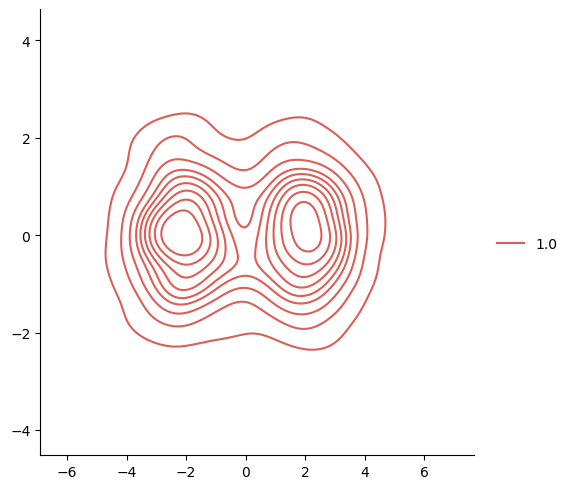

In [61]:
# GM example:
particle1 = GaussianParticle(
    loc=torch.tensor([2,0], dtype=torch.float),
    covariance_matrix=torch.eye(2),
    requires_grad=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-2,0], dtype=torch.float),
    covariance_matrix=torch.eye(2),
    requires_grad=False
)

gm_target = GaussianMixture(particle1)
gm_target.add_particle(particle2)

plot_distribs(lst=[gm_target], nsamples=2000)

We initialize a model with a centered diffuse gaussian:

In [62]:
init = GaussianParticle(
    loc=torch.tensor([0,0], dtype=torch.float),
    covariance_matrix=2*torch.eye(2),
    requires_grad=False
)
gm_model = GaussianMixture(init)

In [63]:
### LET US NOW TRY TO FIT A GM ON THE TARGET ###
K = 2

for i in range(K):
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        covariance_matrix=torch.eye(2),
        requires_grad=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    losses = []
    for step in range(5000):
        loss = FKLLoss(
            f=new_particle,
            q=gm_model,
            p=gm_target,
            nsamples=2000
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        losses.append(loss.detach().numpy())
        if step%300==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    gm_model.add_particle(new_particle)

step:0, loss:0.44570279121398926
step:300, loss:0.38854506611824036
step:600, loss:0.4054751992225647
step:900, loss:0.3869050145149231
step:1200, loss:0.39865875244140625
step:1500, loss:0.34448710083961487
step:1800, loss:0.3607977032661438
step:2100, loss:0.39003801345825195
step:2400, loss:0.3763396739959717
step:2700, loss:0.37425392866134644
step:3000, loss:0.36620041728019714
step:3300, loss:0.33659201860427856
step:3600, loss:0.3627997636795044
step:3900, loss:0.3642769753932953
step:4200, loss:0.34900787472724915
step:4500, loss:0.33994972705841064
step:4800, loss:0.34943509101867676
step:0, loss:0.6833874583244324
step:300, loss:0.4062383770942688
step:600, loss:0.3294217586517334
step:900, loss:0.25573045015335083
step:1200, loss:0.2235669195652008
step:1500, loss:0.1693698912858963
step:1800, loss:0.17253035306930542
step:2100, loss:0.14379137754440308
step:2400, loss:0.1293383687734604
step:2700, loss:0.13250237703323364
step:3000, loss:0.14102375507354736
step:3300, loss:

In [64]:
gm_model.weights

tensor([0.5037, 0.1753, 0.3210])

In [67]:
gm_model.particles[1].loc

Parameter containing:
tensor([-2.2649, -0.0095])

In [68]:
gm_model.particles[2].loc

Parameter containing:
tensor([2.1940, 0.0054])

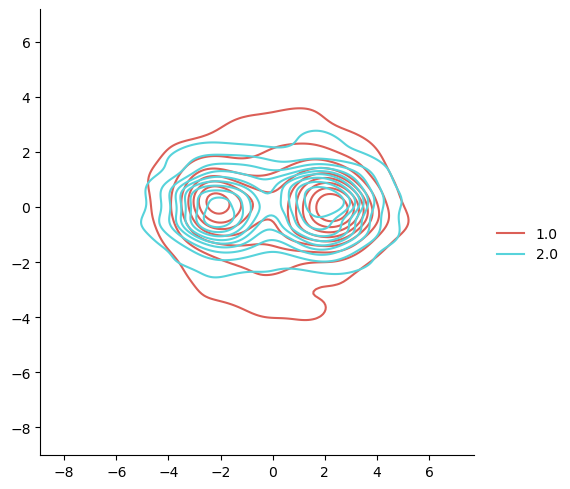

In [65]:
plot_distribs([gm_model, gm_target])

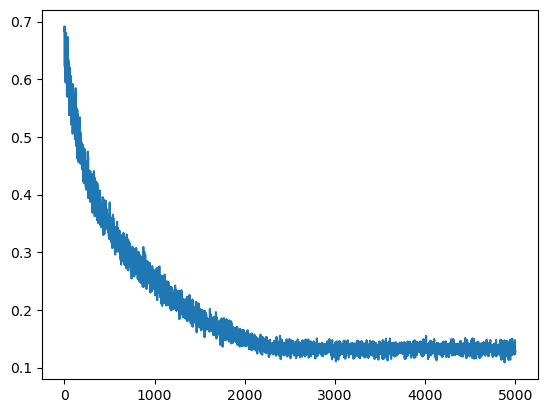

In [66]:
plt.plot(losses)
plt.show()